In [1]:
import re
from typing import List
from pathlib import Path
import pandas as pd
import numpy as np

In [2]:
# CMS complaint data
df = pd.read_csv("CMS_complaints_clean.csv").dropna()


In [3]:
df['Output'] = df['text'].str.count('[\w][\.!\?]')
print (df)

      Unnamed: 0       CCN                              Facility Name  \
0              1   10001.0            SOUTHEAST HEALTH MEDICAL CENTER   
1              2   10001.0            SOUTHEAST HEALTH MEDICAL CENTER   
2              3   10001.0            SOUTHEAST HEALTH MEDICAL CENTER   
3              4   10001.0            SOUTHEAST HEALTH MEDICAL CENTER   
4              5   10001.0            SOUTHEAST HEALTH MEDICAL CENTER   
...          ...       ...                                        ...   
18438      18427  673068.0                   SUGARLAND REHAB HOSPITAL   
18439      18428  673068.0                   SUGARLAND REHAB HOSPITAL   
18440      18429  673068.0                   SUGARLAND REHAB HOSPITAL   
18441      18430  673068.0                   SUGARLAND REHAB HOSPITAL   
18442      18431  673069.0  PAM REHABILITATION HOSPITAL OF ROUND ROCK   

               Street Address        City State  Zip Code Accreditation Type  \
0      1108 ROSS CLARK CIRCLE      DOTHAN  

array([[<AxesSubplot:title={'center':'Output'}>]], dtype=object)

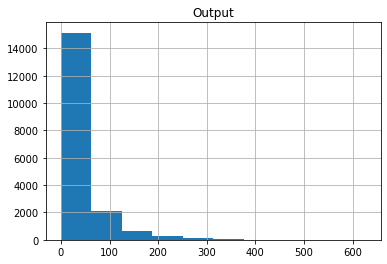

In [4]:
df.hist(column='Output', bins=10)

In [5]:
df['Output'].describe()

count    18431.000000
mean        39.723021
std         52.332484
min          0.000000
25%         10.000000
50%         21.000000
75%         47.000000
max        626.000000
Name: Output, dtype: float64

In [6]:
import textstat

df['Output'] = df['text'].apply(textstat.sentence_count)
print (df)

      Unnamed: 0       CCN                              Facility Name  \
0              1   10001.0            SOUTHEAST HEALTH MEDICAL CENTER   
1              2   10001.0            SOUTHEAST HEALTH MEDICAL CENTER   
2              3   10001.0            SOUTHEAST HEALTH MEDICAL CENTER   
3              4   10001.0            SOUTHEAST HEALTH MEDICAL CENTER   
4              5   10001.0            SOUTHEAST HEALTH MEDICAL CENTER   
...          ...       ...                                        ...   
18438      18427  673068.0                   SUGARLAND REHAB HOSPITAL   
18439      18428  673068.0                   SUGARLAND REHAB HOSPITAL   
18440      18429  673068.0                   SUGARLAND REHAB HOSPITAL   
18441      18430  673068.0                   SUGARLAND REHAB HOSPITAL   
18442      18431  673069.0  PAM REHABILITATION HOSPITAL OF ROUND ROCK   

               Street Address        City State  Zip Code Accreditation Type  \
0      1108 ROSS CLARK CIRCLE      DOTHAN  

array([[<AxesSubplot:title={'center':'Output'}>]], dtype=object)

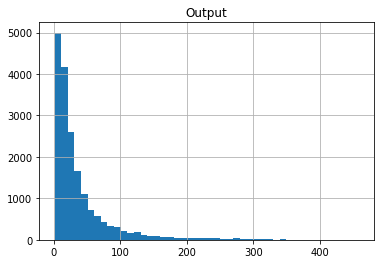

In [7]:
import math
w = 10
n = math.ceil((df['Output'].max() - df['Output'].min())/w)
df.hist(column='Output', bins=n)

In [8]:
df['Output'].describe()


count    18431.000000
mean        37.360534
std         48.098880
min          1.000000
25%         10.000000
50%         21.000000
75%         44.000000
max        459.000000
Name: Output, dtype: float64

array([[<AxesSubplot:title={'center':'Output'}>]], dtype=object)

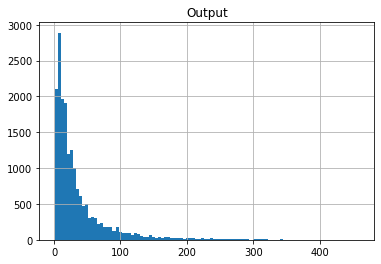

In [9]:
df.hist(column='Output', bins=100)

Distribution of number of words per sentence

In [31]:
df['text'] = df['text'].astype(str)

In [32]:
df['text']

0        20228  This condition level deficiency was cit...
1        20228  Based on observations, review of facili...
2        20228  Based on observations, review of facili...
3        20228  Based on observations, review of facili...
4                                  20228    22965    30952
                               ...                        
18438    30124    Based on observation, interview, and ...
18439    37492  Based on observation, record review and...
18440    10802   Based on observation, record review, a...
18441    10802    Based on observation, interview, and ...
18442    36594  Based on review of medical records and ...
Name: text, Length: 18431, dtype: object

In [40]:
import string
nwords = df['text'].str.split().map(len).sum()
nsenetences = df['text'].count()
nunique_words = len(set([x for i in df['text'].str.split().apply(lambda x: [''.join([y for y in i if y not in string.punctuation]) for i in x]).tolist() for x in i]))

In [37]:
nsenetences

18431

In [38]:
nunique_words

121852

14015478

In [41]:
#crayons
def split_into_sentences(text: str) -> List[str]:
    """Splits a string into list where each entry is a sentence

    Parameters
    ----------
    text : str
        previously cleaned lower case text which can be broken into sentences

    Returns
    -------
    List[str]
        a list where each entry is a sentence in the form of str,
        and we have cleaned out other text which containes fullstops:
        - websites to have the mask <website>
        - standards in the from XYZ.11.11.11 to be <standard>
    """

    # set out the common replacement shorthands
    alphabets = "([A-Za-z])"
    prefixes = "(mr|st|mrs|ms|dr)[.]"
    suffixes = "(inc|ltd|jr|sr|co)"
    starters = r"(mr|mrs|ms|dr|he\s|she\s|it\s|they\s"
    starters += r"|their\s|our\s|we\s|but\s|however\s|that\s|this\s|wherever)"
    standards = r"([a-z]+\.[0-9]+\.[0-9]+\.[0-9]+)"
    acronyms = "([a-z][.][a-z][.](?:[a-z][.])?)"
    websites = "[.](com|net|org|io|gov)"
    url = r"(https?://\S+)"

    # put a fullstop at the end of paragraph without, i.e. at end of bullet points
    text = text.rstrip()
    if not text.endswith("."):
        text = text + "."

    # clean the text up to make sure its standardised
    text = " " + text + "  "
    text = text.replace(r"\n", " ")

    # replace websites and standards with a mask
    text = re.sub(url, "<website>", text)
    text = re.sub(standards, "<standard-number>", text)

    #
    text = re.sub(r"(?<=\d)\.", "<prd>", text)
    text = re.sub(prefixes, "\\1<prd>", text)
    text = re.sub(websites, "<prd>\\1", text)
    # if "Ph.D" in text:
    #    text = text.replace("Ph.D.", "Ph<prd>D<prd>")
    text = re.sub(r"\s" + alphabets + "[.] ", " \\1<prd> ", text)
    text = re.sub(acronyms + " " + starters, "\\1<stop> \\2", text)
    text = re.sub(
        alphabets + "[.]" + alphabets + "[.]" + alphabets + "[.]",
        "\\1<prd>\\2<prd>\\3<prd>",
        text,
    )
    text = re.sub(alphabets + "[.]" + alphabets + "[.]", "\\1<prd>\\2<prd>", text)
    text = re.sub(" " + suffixes + "[.] " + starters, " \\1<stop> \\2", text)
    text = re.sub(" " + suffixes + "[.]", " \\1<prd>", text)
    text = re.sub(" " + alphabets + "[.]", " \\1<prd>", text)

    if "”" in text:
        text = text.replace(".”", "”.")
    if '"' in text:
        text = text.replace('."', '".')
    if "!" in text:
        text = text.replace('!"', '"!')
    if "?" in text:
        text = text.replace('?"', '"?')

    # replace all the sentence ending signifers with a <stop>
    text = text.replace(".", ".<stop>")
    text = text.replace("?", "?<stop>")
    text = text.replace("!", "!<stop>")

    # replace our <prd> holder token with a fullstop
    text = text.replace("<prd>", ".")

    if "<stop>" in text:
        # split on our sentence break <stop>, and clean up
        sentences = text.split("<stop>")
        sentences = sentences[:-1]
        sentences = [s.strip() for s in sentences]
    else:
        sentences = [text.strip()]

    return sentences

In [44]:
df[col].applymap(split_into_sentences)

,text
0,[20228 This condition level deficiency was ci...
1,"[20228 Based on observations, review of facil..."
2,"[20228 Based on observations, review of facil..."
3,"[20228 Based on observations, review of facil..."
4,[20228 22965 30952.]
...,...
18438,"[30124 Based on observation, interview, and..."
18439,"[37492 Based on observation, record review an..."
18440,"[10802 Based on observation, record review, ..."
18441,"[10802 Based on observation, interview, and..."


In [45]:
col=["text"]
df['text'][0]

"20228  This condition level deficiency was cited based on observations, review of facility policies, Facility Scope of Care Behavioral Health Services (BHS) / Behavioral Medicine Unit (BMU), facility work order maintenance requests, security video footage, Root Cause Analysis (RCA), medical records, Risk Management Worksheets, Unit Profile reports, Safety Checklist documentation, Minutes Houston County Health Care Authority Quality Committee, interviews and Facility's Corrective Action Plan submitted to the surveyors on 8/24/17, it was determined the governing body failed to ensure:  1. Psychiatric patients were provided care in a safe environment.   2. Mental Health Technicians (MHTs) performed patient safety rounds every 15 minutes.   3. The Registered Nurse (RN) conducted hourly rounds on patients and supervised the care provided by the MHTs to ensure patient observations were conducted every 15 minutes according to physician orders.  4. The BMU staff recognized the complexity of P

In [47]:
def process(txt):
    return split_into_sentences(txt)[0].split("  ")

col = ["text"]
df[col] = df[col].applymap(process) 

In [54]:
df[col].iloc[0].values

array([list(['20228', "This condition level deficiency was cited based on observations, review of facility policies, Facility Scope of Care Behavioral Health Services (BHS) / Behavioral Medicine Unit (BMU), facility work order maintenance requests, security video footage, Root Cause Analysis (RCA), medical records, Risk Management Worksheets, Unit Profile reports, Safety Checklist documentation, Minutes Houston County Health Care Authority Quality Committee, interviews and Facility's Corrective Action Plan submitted to the surveyors on 8/24/17, it was determined the governing body failed to ensure:", '1. Psychiatric patients were provided care in a safe environment.'])],
      dtype=object)